In [21]:
from matplotlib import pyplot as plt 
import graphsim
import numpy as np
import pathlib
import math
from scipy import optimize
from scipy import stats
from pdb import set_trace
from cycler import cycler

%matplotlib inline

# Definitions

In [2]:
def power_law_fit(N, a, b, y0):
    
    return b*np.power(N,a) + y0

def constant_fit(x, c):
    
    return np.full(x.shape,c)

def tripartite_info(gr,N):
    
    A = int(N/4)
    B = A
    C = A
    D = A
        
    S_ABC = gr.entEntropy(range(A+B+C))
    S_AB = gr.entEntropy(range(A+B))
    S_BC = gr.entEntropy(range(A,A+B+C))
    S_AC = gr.entEntropy(np.concatenate((np.arange(A), np.arange(A+B,A+B+C))))
    S_A = gr.entEntropy(range(A))
    S_B = gr.entEntropy(range(B))
    S_C = gr.entEntropy(range(B,B+C))
    
    return S_ABC - S_AB - S_BC - S_AC + S_A + S_B + S_C

def convert_snake1D_to_2D(v,L):
    row = math.floor(v/L)
    rem = v - row*L
    column = (1 - (row%2))*rem + (row%2) * (L-1-rem)
    return row, column

def convert_2D_to_snake1D(row,column,L):
    return L*row + (1-(row%2))*column + (row%2) * (L-1-column)

def get_neighbour(v,clock_parity,L):
    
    v_row, v_column = convert_snake1D_to_2D(v,L)
    if clock_parity==0:
        neighbour_row = (v_row - 1) % L
        neighbour_column = v_column
    elif clock_parity==1:
        neighbour_row = v_row
        neighbour_column = (v_column + 1) % L
    elif clock_parity==2:
        neighbour_row = (v_row + 1) % L
        neighbour_column = v_column
    else:
        neighbour_row = v_row
        neighbour_column = (v_column - 1) % L
                
    v_neighbour = convert_2D_to_snake1D(neighbour_row,neighbour_column,L)
    
    return v_neighbour


def objective_w_function(x,y,d,x1,y1,d1,x2,y2,d2):
    
#     if (np.isclose(x1,x2) or np.isclose(x,x1) or np.isclose(x,x2)):
#         w = 10 * np.max(np.abs([y-y1,y2-y])) / np.min([d,d1,d2])
#     else:
    ybar = ((x2-x)*y1 - (x1-x)*y2) / (x2-x1)
    delta_sq = d**2 + ((x2-x)*d1/(x2-x1))**2 + ((x1-x)*d2/(x2-x1))**2
#         if np.isclose(delta_sq,0):
#             w = 10 * np.max([y-y1,y2-y])
#         else:
    w = (y - ybar)**2 / delta_sq
#     w = (y - ybar)**2 / ybar**2
    
    return w

# Testing

In [5]:
# Parameters

N = 40
num_steps = 20*N 
num_samples = 100 
prob = 0.001
num_disorder_realizations = 100

sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)

unaveraged_entropies_vs_time = np.zeros((num_samples,num_disorder_realizations))

A = int(N/2)
ent_subsystem = np.arange(A).tolist()

1min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


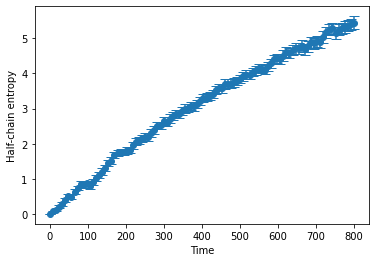

In [6]:
%%timeit -n 1 -r 1

# Main

for m in range(num_disorder_realizations):
    
    gr = graphsim.GraphRegister(N)

    for n in range(num_steps):

        parity = n % 2 
        for v in range(parity, parity+N, 2): 
#             gate_type = np.random.randint(0,3)
#             if gate_type==0:
#                 gr.cphase(v,(v+1)%N)
#             elif gate_type==1:
#                 gr.hadamard(v)
#             else:
#                 gr.phaserot(v)
            gate_type = np.random.choice([0,1,2,3,4],p=[0.95,0.0125,0.0125,0.0125,0.0125])
            if gate_type==0:
                gr.cphase(v,(v+1)%N)
            elif gate_type==1:
                gr.hadamard(v)
                gr.hadamard((v+1)%N)
            elif gate_type==2:
                gr.hadamard(v)
                gr.phaserot((v+1)%N)
            elif gate_type==3:
                gr.phaserot(v)
                gr.hadamard((v+1)%N)
            else:
                gr.phaserot(v)
                gr.phaserot((v+1)%N)

        measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
        measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

        for v in measured_indices:
            gr.measure(v)

        if sample_time_check_list[n+1]:
            index = np.argwhere(sample_times == n+1)
            unaveraged_entropies_vs_time[index,m] = gr.entEntropy(ent_subsystem)
            
mean_entropies_vs_time = np.mean(unaveraged_entropies_vs_time, axis=1)
std_entropies_vs_time = np.sqrt(np.var(unaveraged_entropies_vs_time, axis=1) / num_disorder_realizations)

plt.errorbar(sample_times, mean_entropies_vs_time, yerr=std_entropies_vs_time, marker='o', capsize=5)
plt.xlabel("Time")
plt.ylabel("Half-chain entropy")

# Performance profiling

In [1]:
%%writefile simulation.py

import graphsim
import numpy as np

# Parameters

N = 512 
num_steps = 20*N 
num_samples = 100 
prob = 0

sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)

unaveraged_entropies_vs_time = np.zeros(num_samples)
A = int(N/2)
ent_subsystem = np.arange(A).tolist()

def simulate():

    # Main

    gr = graphsim.GraphRegister(N)

    for n in range(num_steps):

        parity = n % 2 
        for v in range(parity, parity+N, 2): 
            gate_type = np.random.randint(0,3)
            if gate_type==0:
                gr.cphase(v,(v+1)%N)
            elif gate_type==1:
                gr.hadamard(v)
            else:
                gr.phaserot(v)

        measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
        measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

        for v in measured_indices:
            gr.measure(v)

        if sample_time_check_list[n+1]:
            index = np.argwhere(sample_times == n+1)
            unaveraged_entropies_vs_time[index] = gr.entEntropy(ent_subsystem)

Overwriting simulation.py


In [2]:
from simulation import simulate
%load_ext line_profiler

In [3]:
%lprun -T lprof0 -f simulate simulate()


*** Profile printout saved to text file 'lprof0'. 


#### $p=0$ runtimes

Time for simulation between $0 \leq t \leq 20N$.

 N | Runtime (s)
---|------------
 50|      1.7
100|     15
150|     75
200|    245
250|    668
512|  12563

In [7]:
N_array = np.array([50,100,150,200,250,512])
runtimes = [1.7,15,75,245,668,12563]

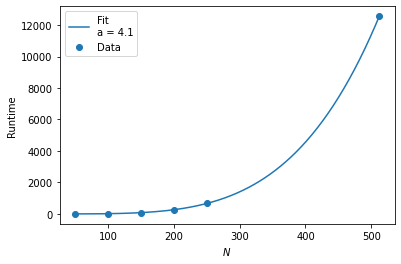

In [8]:
plt.scatter(N_array, runtimes, marker='o', label='Data')

popt, pcov = optimize.curve_fit(power_law_fit, N_array, runtimes, p0=[2,1,0])

smoothed_N_array = np.arange(N_array[0],N_array[-1])
plt.plot(smoothed_N_array, power_law_fit(smoothed_N_array,*popt), label='Fit\na = {:.3g}'.format(popt[0]))

plt.xlabel(r"$N$")
plt.ylabel("Runtime")
plt.legend()

Why is this scaling as $\mathcal{O}(N^4)$? One factor of $N$ is obviously from the scaling of the total runtime with $N$. But should the cost of the cphase gate really scale as $\mathcal{O}(N^3)$? I suppose in the volume phase we might have the typical degree scaling as $\mathcal{O}(N)$ rather than $\mathcal{O}(\log{N})$.

# Locating critical point using I3

## Generate data

In [11]:
# Parameters

N_array = [40,80,120,160,200]
num_samples = 100 
prob_min= 0.005
prob_max = 0.015
num_prob_steps = 11
prob_array = np.linspace(prob_min, prob_max, num_prob_steps, endpoint=True)
num_disorder_realizations = 100

unaveraged_I3_vs_t_p_N = np.zeros((num_disorder_realizations,num_samples,num_prob_steps,len(N_array)))

In [62]:
for N_index, N in enumerate(N_array):
    num_steps = 4*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
    sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)
    for prob_index, prob in enumerate(prob_array):
        print(f"N = {N}, prob = {prob:.3g}")
        for m in range(num_disorder_realizations):
                
            gr = graphsim.GraphRegister(N)

            for n in range(num_steps):

                parity = n % 2 
                for v in range(parity, parity+N, 2): 
                    gate_type = np.random.randint(0,3)
                    if gate_type==0:
                        gr.cphase(v,(v+1)%N)
                    elif gate_type==1:
                        gr.hadamard(v)
                    else:
                        gr.phaserot(v)

                measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
                measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

                for v in measured_indices:
                    gr.measure(v)

                if sample_time_check_list[n+1]:
                    index = np.argwhere(sample_times == n+1)
                    unaveraged_I3_vs_t_p_N[m,index,prob_index,N_index] = tripartite_info(gr,N)

N = 40, prob = 0.005
N = 40, prob = 0.006
N = 40, prob = 0.007
N = 40, prob = 0.008
N = 40, prob = 0.009
N = 40, prob = 0.01
N = 40, prob = 0.011
N = 40, prob = 0.012
N = 40, prob = 0.013
N = 40, prob = 0.014
N = 40, prob = 0.015
N = 80, prob = 0.005
N = 80, prob = 0.006
N = 80, prob = 0.007
N = 80, prob = 0.008
N = 80, prob = 0.009
N = 80, prob = 0.01
N = 80, prob = 0.011
N = 80, prob = 0.012
N = 80, prob = 0.013
N = 80, prob = 0.014
N = 80, prob = 0.015
N = 120, prob = 0.005
N = 120, prob = 0.006
N = 120, prob = 0.007
N = 120, prob = 0.008
N = 120, prob = 0.009
N = 120, prob = 0.01
N = 120, prob = 0.011
N = 120, prob = 0.012
N = 120, prob = 0.013
N = 120, prob = 0.014
N = 120, prob = 0.015
N = 160, prob = 0.005
N = 160, prob = 0.006
N = 160, prob = 0.007
N = 160, prob = 0.008
N = 160, prob = 0.009
N = 160, prob = 0.01
N = 160, prob = 0.011
N = 160, prob = 0.012
N = 160, prob = 0.013
N = 160, prob = 0.014
N = 160, prob = 0.015
N = 200, prob = 0.005
N = 200, prob = 0.006
N = 200, prob 

In [ ]:
np.save("unaveraged_I3_vs_t_p_N.npy", unaveraged_I3_vs_t_p_N)

### Testing time evolution of I3

In [105]:
# Parameters

N_array = [4096]
num_samples = 100 
prob_min= 0.2
prob_max = 0.2
num_prob_steps = 1
prob_array = np.linspace(prob_min, prob_max, num_prob_steps, endpoint=True)
num_disorder_realizations = 1

unaveraged_I3_vs_t_p_N = np.zeros((num_disorder_realizations,num_samples,num_prob_steps,len(N_array)))

In [106]:
for N_index, N in enumerate(N_array):
    num_steps = 2*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
    sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)
    for prob_index, prob in enumerate(prob_array):
        print(f"N = {N}, prob = {prob:.3g}")
        for m in range(num_disorder_realizations):
                
            gr = graphsim.GraphRegister(N)

            for n in range(num_steps):
                
                if (n % 100 == 0):
                    print(f"n = {n}")

                parity = n % 2 
                for v in range(parity, parity+N, 2): 
#                     gate_type = np.random.randint(0,3)
#                     if gate_type==0:
#                         gr.cphase(v,(v+1)%N)
#                     elif gate_type==1:
#                         gr.hadamard(v)
#                     else:
#                         gr.phaserot(v)
                    gate_type = np.random.choice([0,1,2,3,4],p=[0.95,0.0125,0.0125,0.0125,0.0125])
                    if gate_type==0:
#                         gr.cphase(v,(v+1)%N)
                        gr.cnot(v,(v+1)%N)
                    elif gate_type==1:
                        gr.hadamard(v)
                        gr.hadamard((v+1)%N)
                    elif gate_type==2:
                        gr.hadamard(v)
                        gr.phaserot((v+1)%N)
                    elif gate_type==3:
                        gr.phaserot(v)
                        gr.hadamard((v+1)%N)
                    else:
                        gr.phaserot(v)
                        gr.phaserot((v+1)%N)

                measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
                measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

                for v in measured_indices:
                    gr.measure(v)

                if sample_time_check_list[n+1]:
                    index = np.argwhere(sample_times == n+1)
                    unaveraged_I3_vs_t_p_N[m,index,prob_index,N_index] = tripartite_info(gr,N)

N = 4096, prob = 0.2
n = 0
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000
n = 1100
n = 1200
n = 1300
n = 1400
n = 1500
n = 1600
n = 1700
n = 1800
n = 1900
n = 2000
n = 2100
n = 2200
n = 2300
n = 2400
n = 2500
n = 2600
n = 2700
n = 2800
n = 2900
n = 3000
n = 3100
n = 3200
n = 3300
n = 3400
n = 3500
n = 3600
n = 3700
n = 3800
n = 3900
n = 4000
n = 4100
n = 4200
n = 4300
n = 4400
n = 4500
n = 4600
n = 4700
n = 4800
n = 4900
n = 5000
n = 5100
n = 5200
n = 5300
n = 5400
n = 5500
n = 5600
n = 5700
n = 5800
n = 5900
n = 6000
n = 6100
n = 6200
n = 6300
n = 6400
n = 6500
n = 6600
n = 6700
n = 6800
n = 6900
n = 7000
n = 7100
n = 7200
n = 7300
n = 7400
n = 7500
n = 7600
n = 7700
n = 7800
n = 7900
n = 8000
n = 8100


In [107]:
mean_I3_vs_t_p_N = np.mean(unaveraged_I3_vs_t_p_N, axis=0)
std_I3_vs_t_p_N = np.sqrt(np.var(unaveraged_I3_vs_t_p_N, axis=0) / num_disorder_realizations)

Text(0, 0.5, '$I_{3}$')

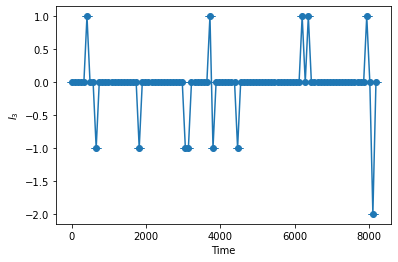

In [108]:
N_index=0
prob_index=0

plt.errorbar(sample_times, mean_I3_vs_t_p_N[:,prob_index,N_index], yerr=std_I3_vs_t_p_N[:,prob_index,N_index],
                     marker='o', capsize=5)
plt.xlabel("Time")
plt.ylabel(r"$I_{3}$")
#         plt.title(f"N = {N}, p = {prob:.3g}")


With $\mathbb{P}(CZ) = 0.95$, the saturation time for I3 for N=40 and p=0 is $t \approx 2500$.

Using CNOTs, on the other hand, the saturation time with $\mathbb{P}(CNOT) = 0.95$, N=40 and p=0 is *much* shorter, at $t \approx 50$.

So in this particular circuit setup, CNOTs seem much more effective entangling gates than CZs. Perhaps this is why the critical probability is so low using CZs.

For $p=0.005$,

 N | -I3
---|----
40 |  6
80 |  12

so it looks like $p_{c} > 0.005$.

For $p=0.01$,

 N | -I3
---|----
40 |  1.25
80 |  2

so it looks like $p_{c} > 0.01$. (Note that I needed 500 disorder realizations to get reasonable results for $N=80$.)

It looks like the saturation runtime possibly *increases* with $p$, which is the opposite behaviour to what I observed in my MBL circuits. Is this weird? On the one hand, perhaps the measurements cause the entanglement to grow more slowly. But also, the steady state entanglement decreases with $p$, so one would have thought these effects would balance somehow.

### Time evolution of average vertex degree

In [14]:
# Parameters

N_array = [40,80,120]
num_samples = 100 
prob_min= 0
prob_max = 0
num_prob_steps = 1
prob_array = np.linspace(prob_min, prob_max, num_prob_steps, endpoint=True)
num_disorder_realizations = 10

unaveraged_d_vs_t_p_N = np.zeros((num_disorder_realizations,num_samples,num_prob_steps,len(N_array)))

In [15]:
for N_index, N in enumerate(N_array):
    num_steps = 2*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
    sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)
    for prob_index, prob in enumerate(prob_array):
        print(f"N = {N}, prob = {prob:.3g}")
        for m in range(num_disorder_realizations):
                
            gr = graphsim.GraphRegister(N)

            for n in range(num_steps):
                
#                 if (n % 100 == 0):
#                     print(f"n = {n}")

                parity = n % 2 
                for v in range(parity, parity+N, 2): 
#                     gate_type = np.random.randint(0,3)
#                     if gate_type==0:
#                         gr.cphase(v,(v+1)%N)
#                     elif gate_type==1:
#                         gr.hadamard(v)
#                     else:
#                         gr.phaserot(v)
                    gate_type = np.random.choice([0,1,2,3,4],p=[0.95,0.0125,0.0125,0.0125,0.0125])
                    if gate_type==0:
#                         gr.cphase(v,(v+1)%N)
                        gr.cnot(v,(v+1)%N)
                    elif gate_type==1:
                        gr.hadamard(v)
                        gr.hadamard((v+1)%N)
                    elif gate_type==2:
                        gr.hadamard(v)
                        gr.phaserot((v+1)%N)
                    elif gate_type==3:
                        gr.phaserot(v)
                        gr.hadamard((v+1)%N)
                    else:
                        gr.phaserot(v)
                        gr.phaserot((v+1)%N)

                measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
                measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

                for v in measured_indices:
                    gr.measure(v)

                if sample_time_check_list[n+1]:
                    index = np.argwhere(sample_times == n+1)
                    unaveraged_d_vs_t_p_N[m,index,prob_index,N_index] = gr.degreeSum / N

N = 40, prob = 0
N = 80, prob = 0
N = 120, prob = 0


In [16]:
mean_d_vs_t_p_N = np.mean(unaveraged_d_vs_t_p_N, axis=0)
std_d_vs_t_p_N = np.sqrt(np.var(unaveraged_d_vs_t_p_N, axis=0) / num_disorder_realizations)

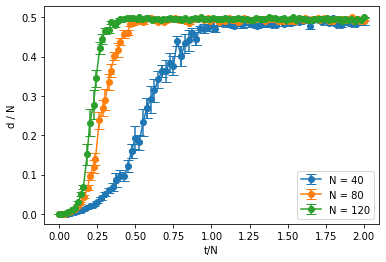

In [17]:
prob_index = 0

for N_index, N in enumerate(N_array):
    
    num_steps = 2*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)

    plt.errorbar(sample_times/N, mean_d_vs_t_p_N[:,prob_index,N_index]/N, yerr=std_d_vs_t_p_N[:,prob_index,N_index]/N,
                         marker='o', capsize=5, label=f'N = {N}')
plt.xlabel("t/N")
plt.ylabel("d / N")
plt.legend()
#         plt.title(f"N = {N}, p = {prob:.3g}")


Why does $d/N$ saturate at 0.5, and not something higher?

## Data analysis

In [12]:
unaveraged_I3_vs_t_p_N = np.load("unaveraged_I3_vs_t_p_N.npy")
mean_I3_vs_t_p_N = np.mean(unaveraged_I3_vs_t_p_N, axis=0)
std_I3_vs_t_p_N = np.sqrt(np.var(unaveraged_I3_vs_t_p_N, axis=0) / num_disorder_realizations)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

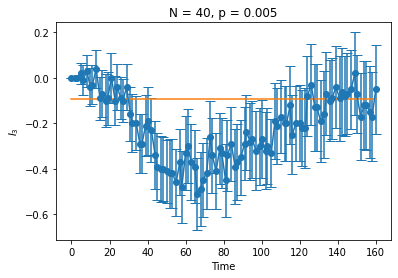

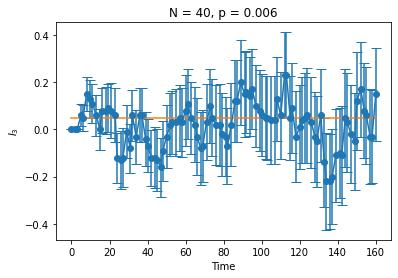

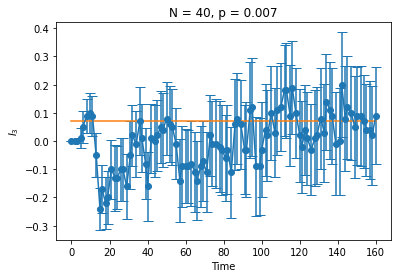

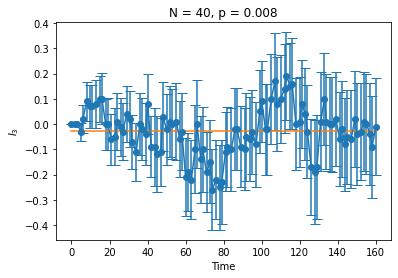

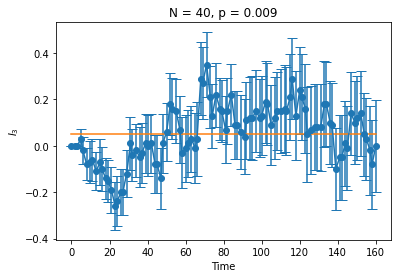

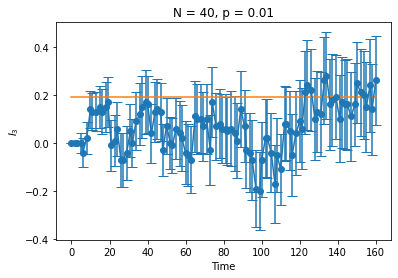

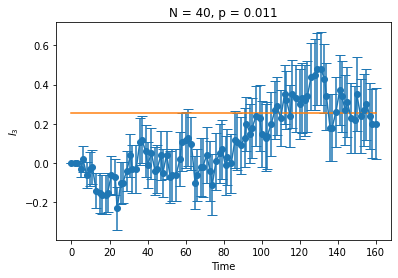

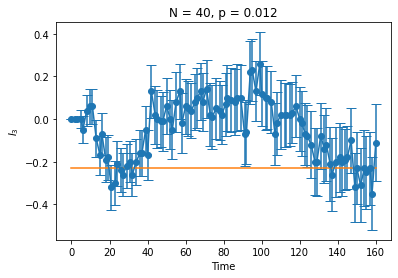

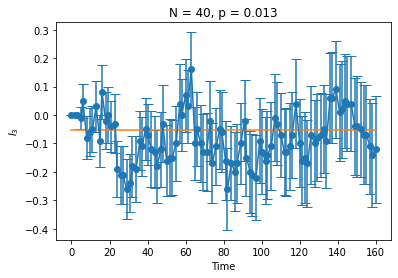

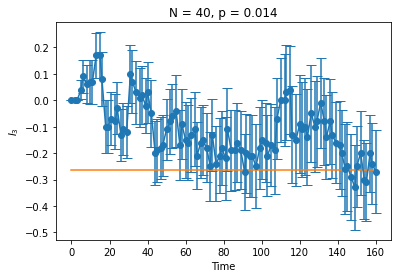

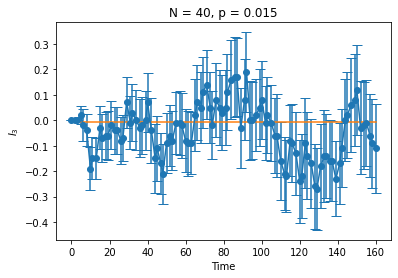

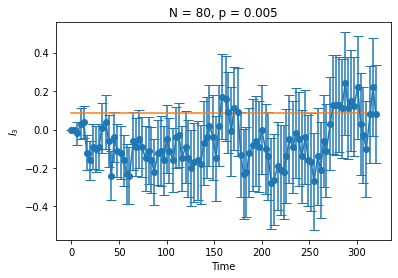

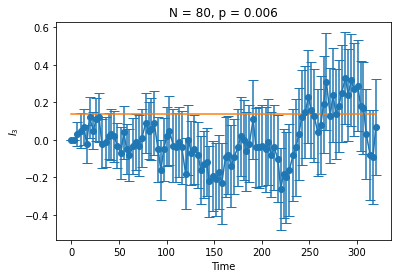

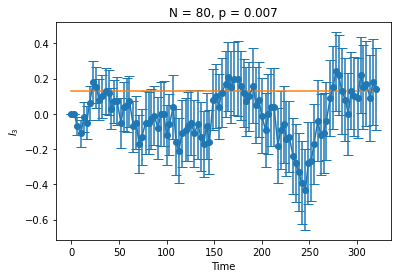

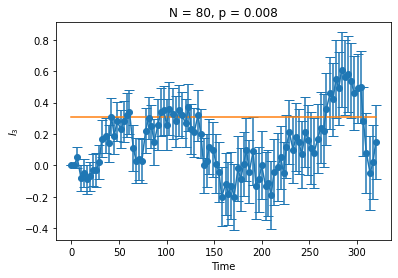

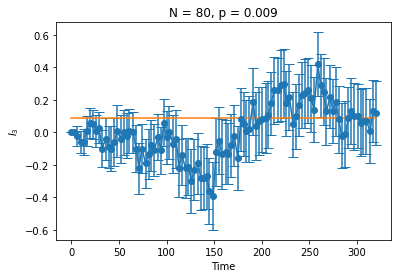

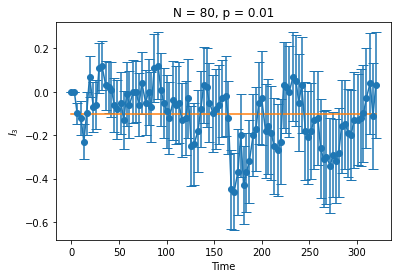

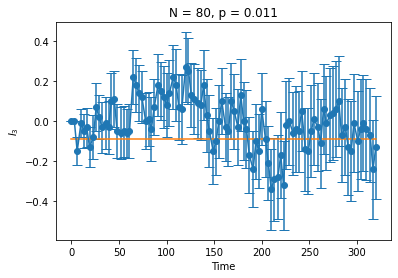

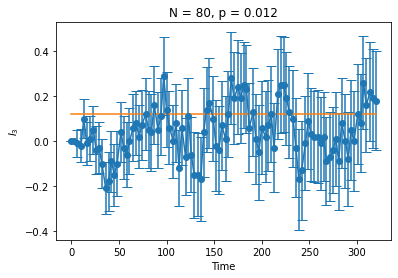

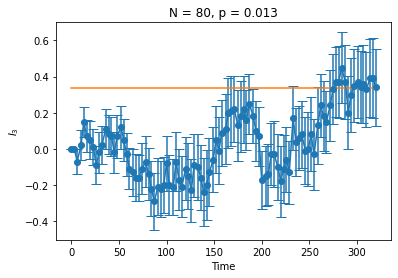

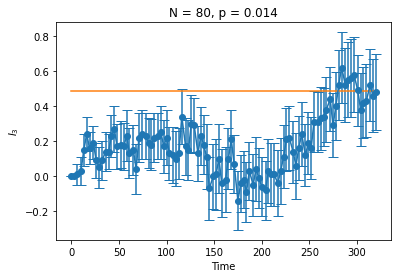

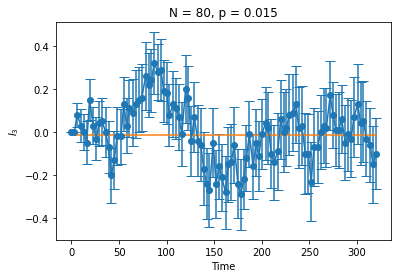

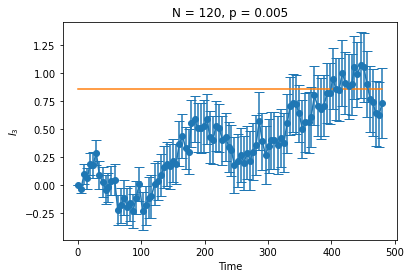

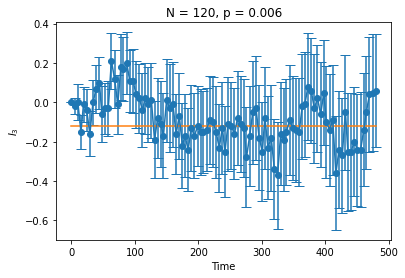

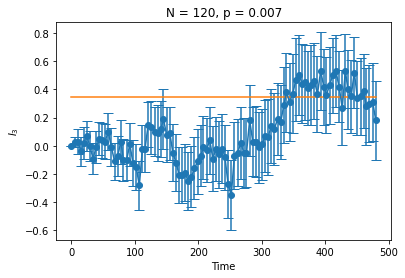

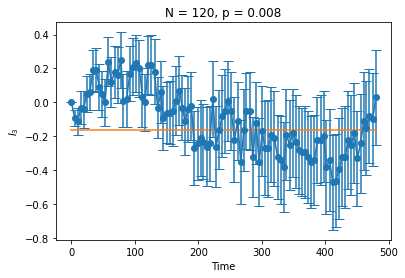

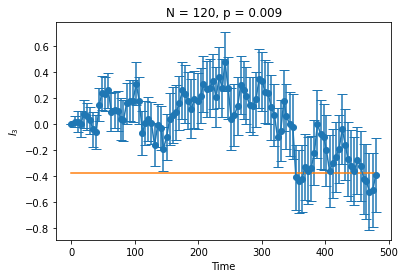

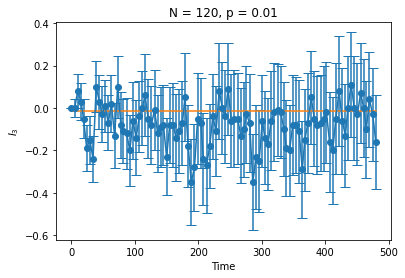

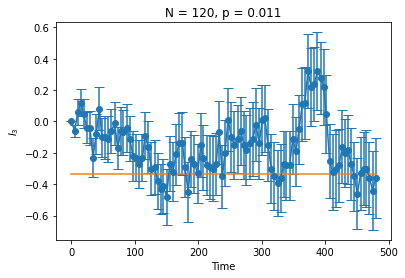

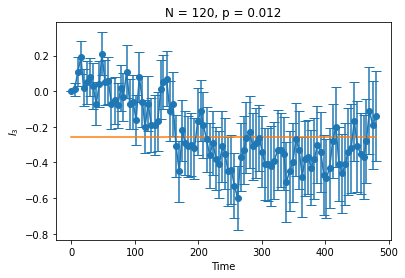

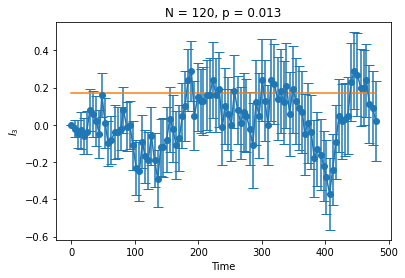

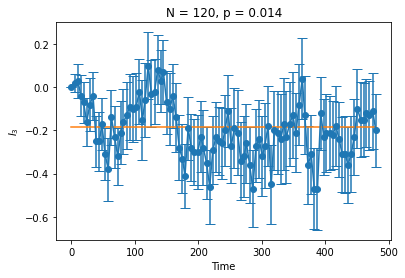

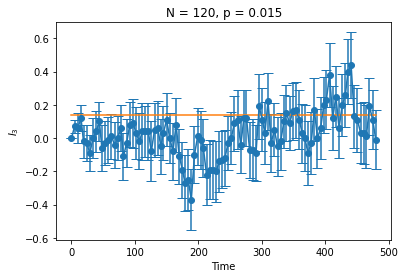

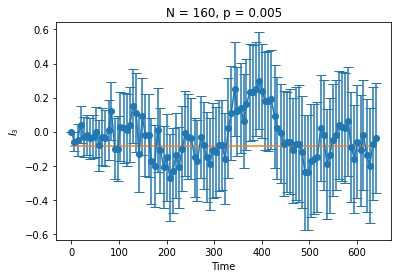

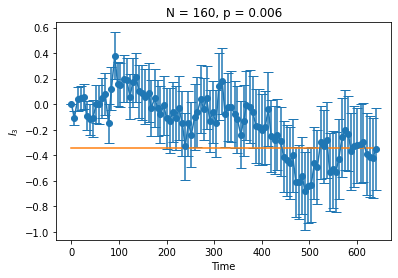

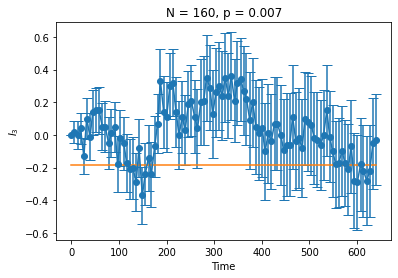

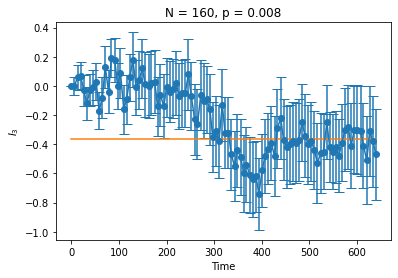

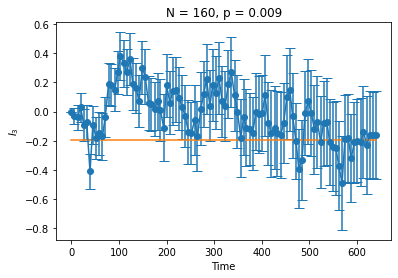

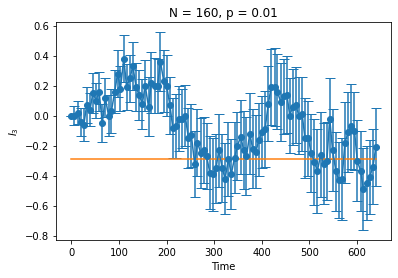

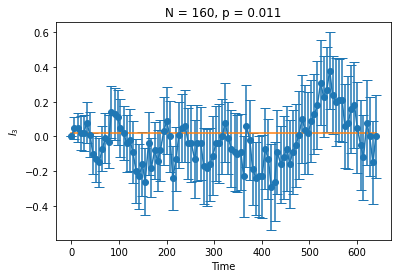

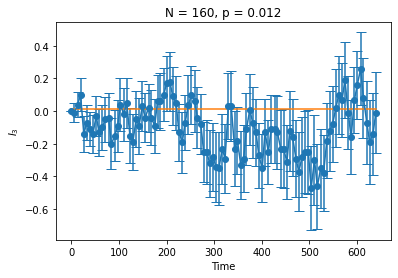

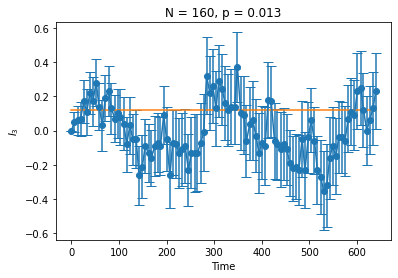

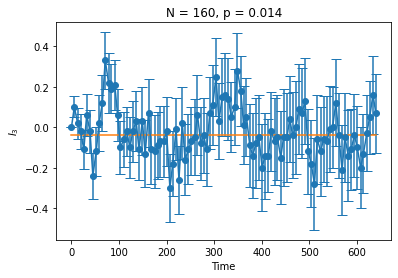

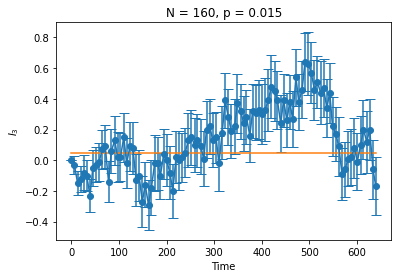

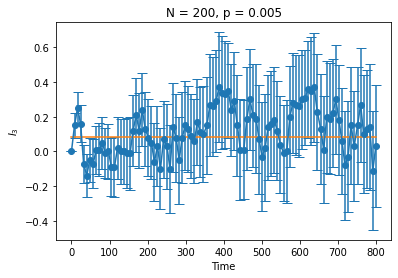

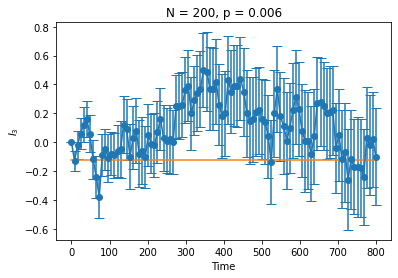

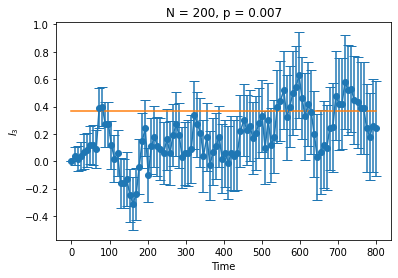

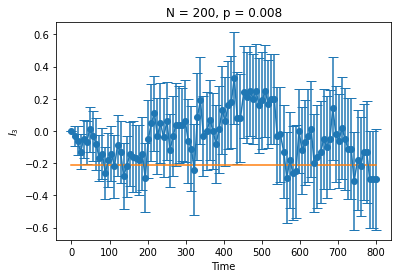

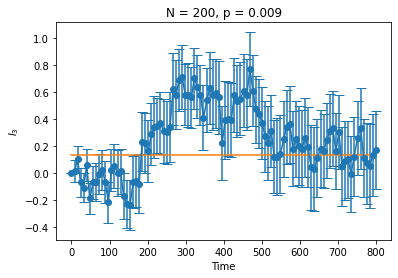

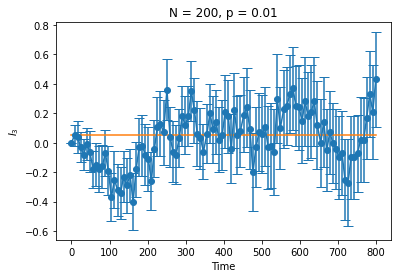

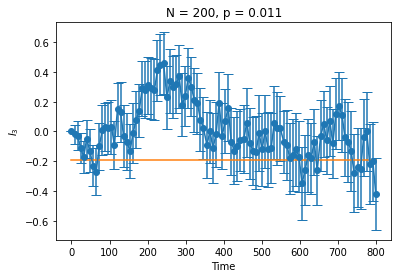

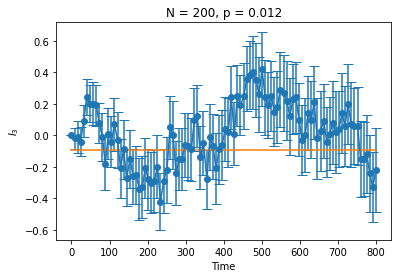

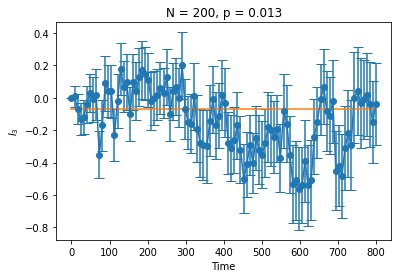

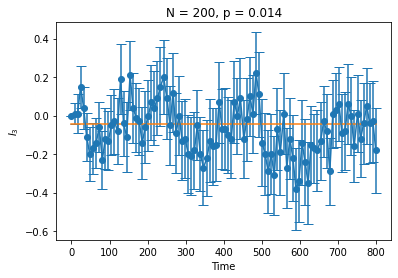

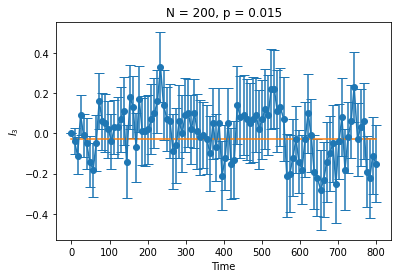

In [19]:
saturated_I3_vs_p_N = np.zeros((num_prob_steps, len(N_array)))
saturated_I3_error_vs_p_N = saturated_I3_vs_p_N.copy()

fit_start_index = int(0.9*num_samples)

for N_index, N in enumerate(N_array):
    num_steps = 4*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
    for prob_index, prob in enumerate(prob_array):
        fig, ax = plt.subplots()
        plt.errorbar(sample_times, mean_I3_vs_t_p_N[:,prob_index,N_index], yerr=std_I3_vs_t_p_N[:,prob_index,N_index],
                     marker='o', capsize=5)
        plt.xlabel("Time")
        plt.ylabel(r"$I_{3}$")
        plt.title(f"N = {N}, p = {prob:.3g}")
        
        popt, pcov = optimize.curve_fit(constant_fit, sample_times[fit_start_index:], mean_I3_vs_t_p_N[fit_start_index:,prob_index,N_index],
                                        sigma=std_I3_vs_t_p_N[fit_start_index:,prob_index,N_index],
                                        absolute_sigma=True)
        plt.plot(sample_times, constant_fit(sample_times,*popt))
        saturated_I3_vs_p_N[prob_index,N_index] = popt[0]
        saturated_I3_error_vs_p_N[prob_index,N_index] = np.sqrt(pcov[0,0])

## Cluster simulations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

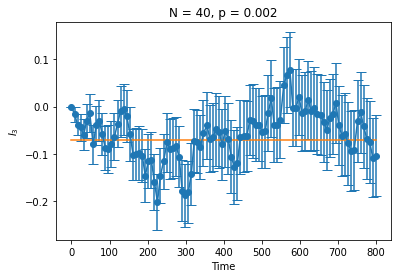

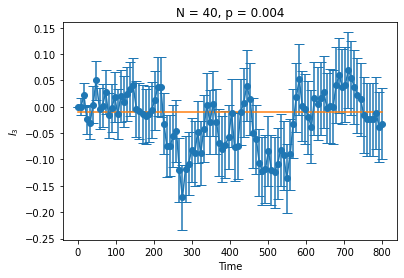

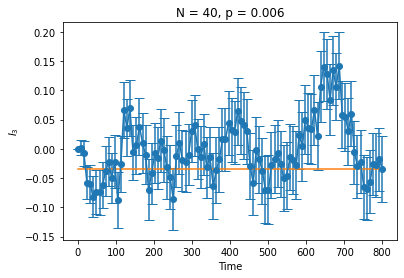

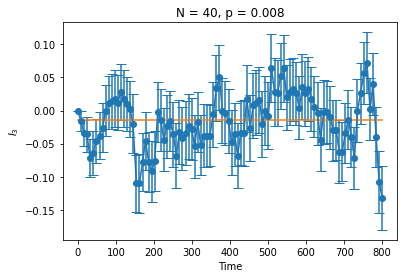

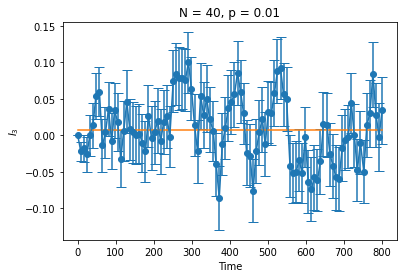

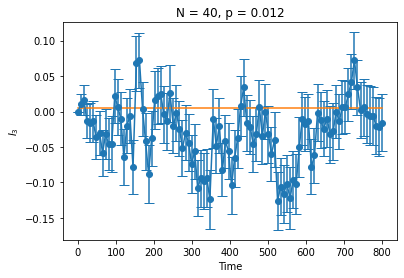

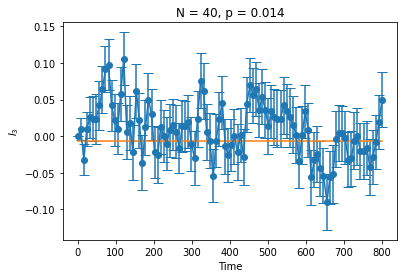

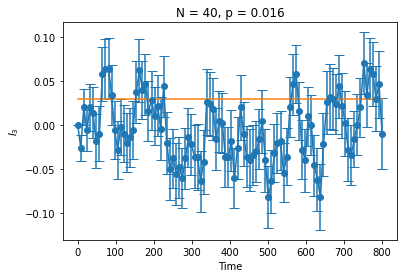

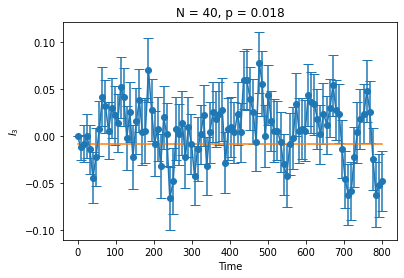

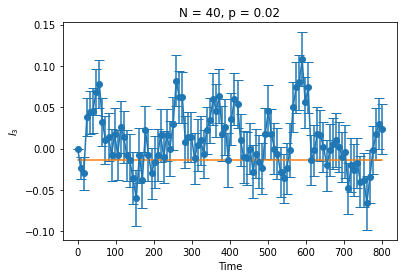

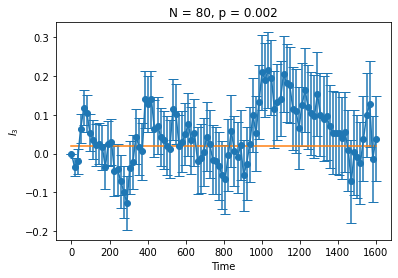

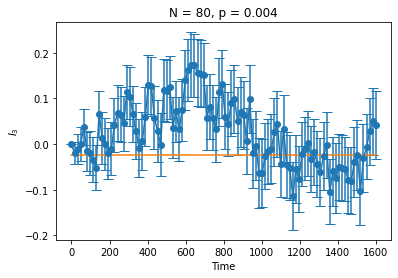

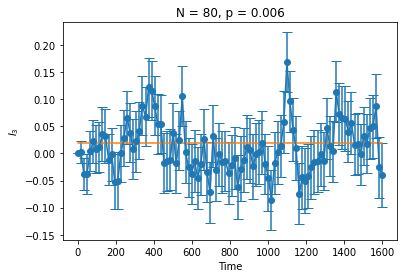

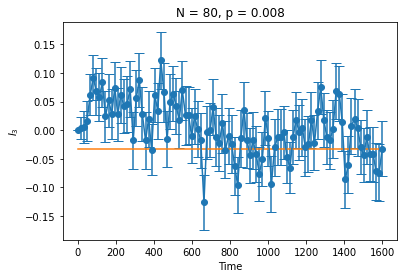

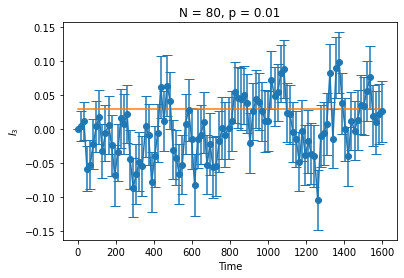

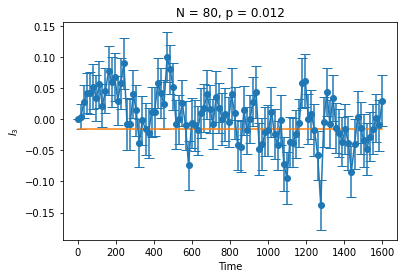

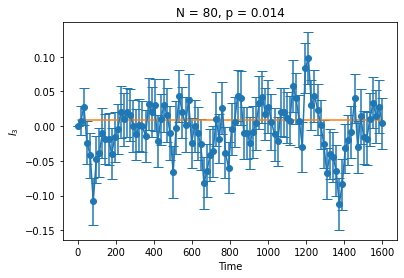

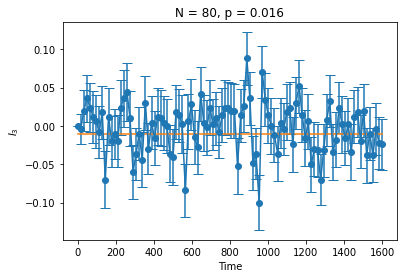

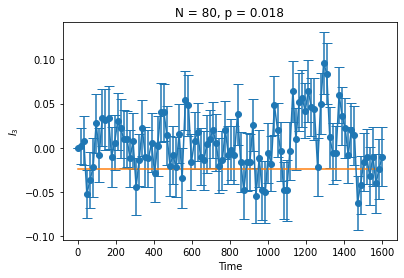

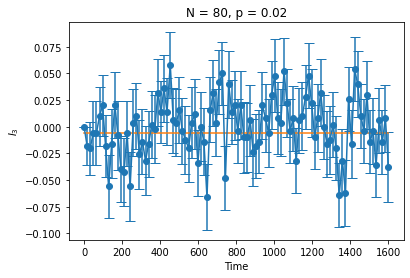

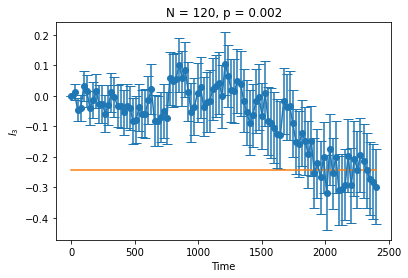

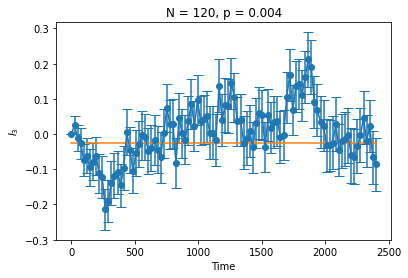

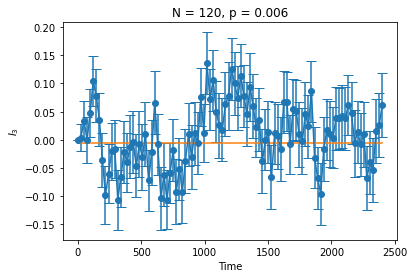

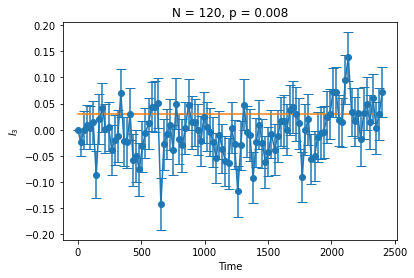

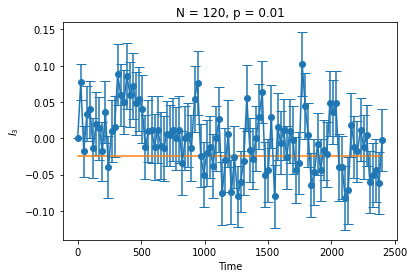

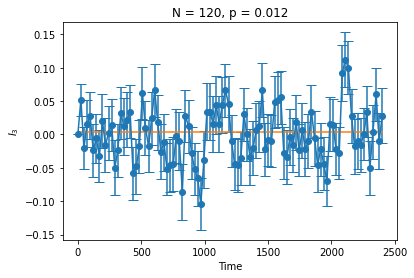

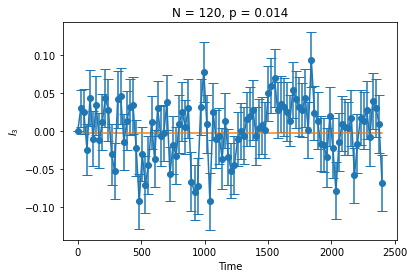

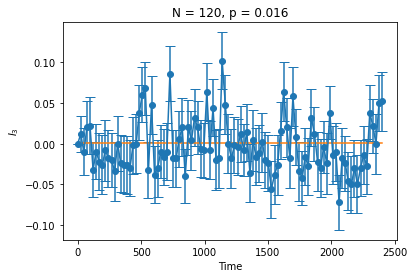

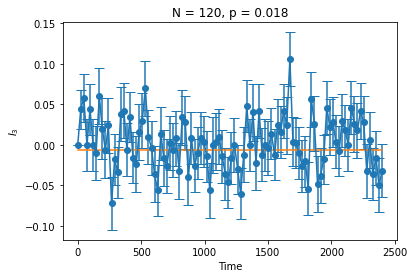

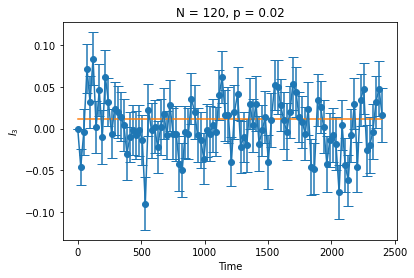

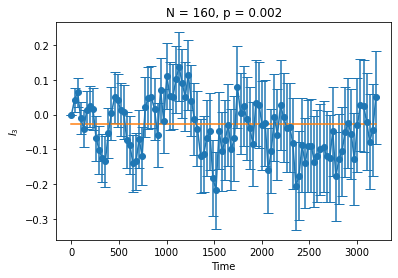

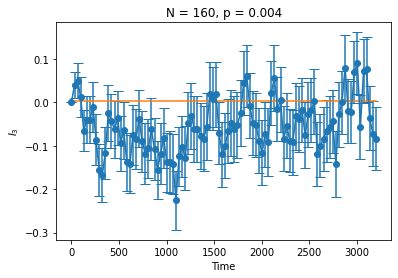

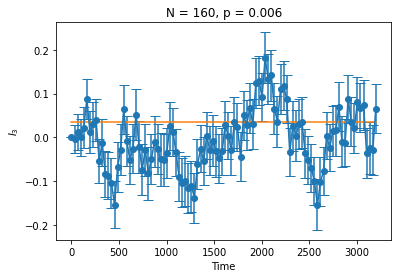

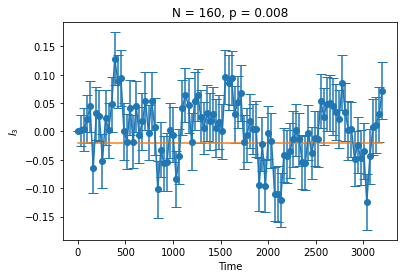

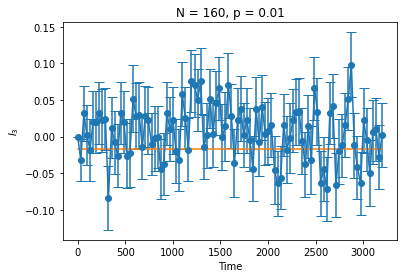

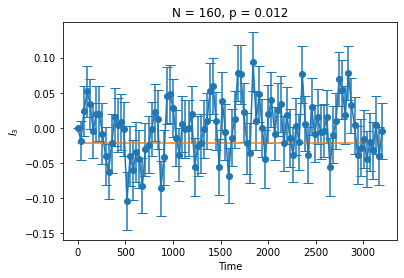

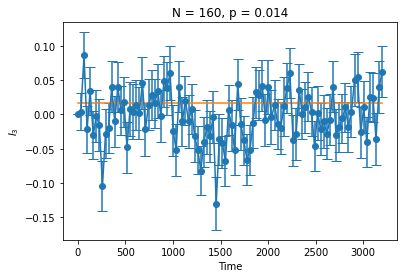

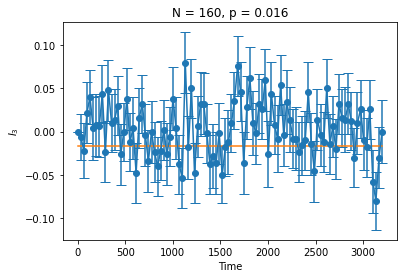

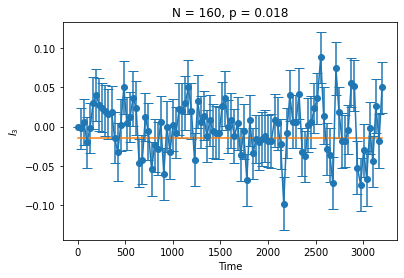

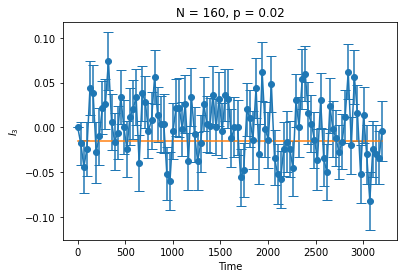

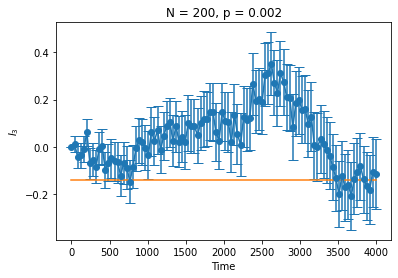

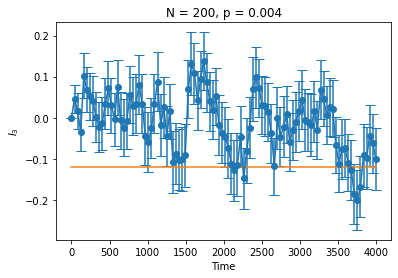

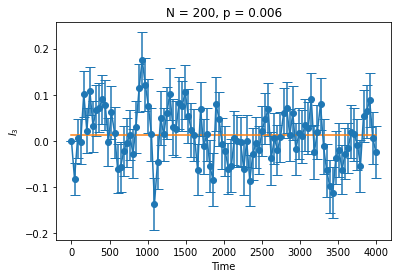

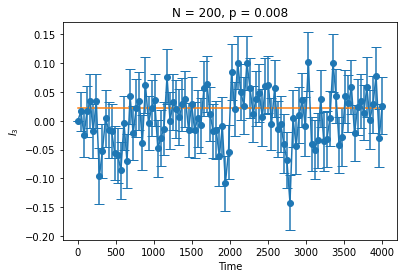

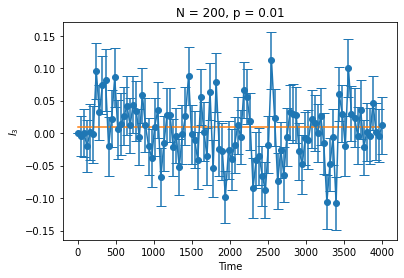

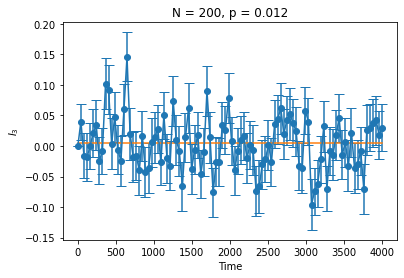

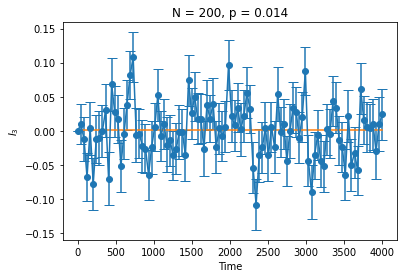

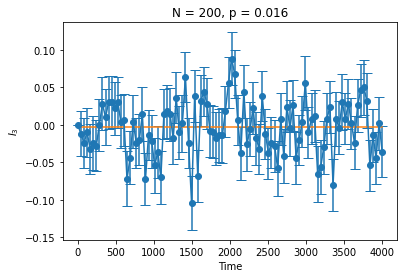

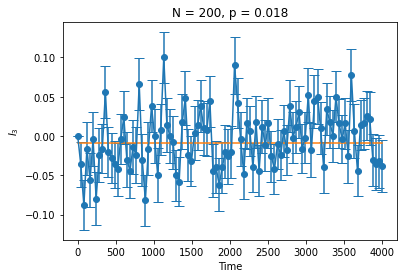

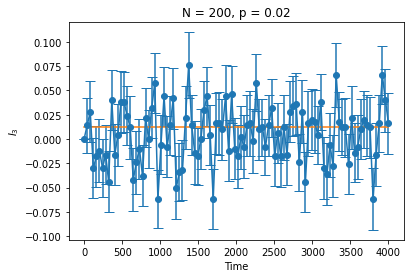

In [4]:
N_min= 40
N_max = 200
num_N_steps = 5
N_array = np.linspace(N_min, N_max, num_N_steps, dtype=int)
prob_min= 0.002
prob_max = 0.02
num_prob_steps = 10
prob_array = np.linspace(prob_min, prob_max, num_prob_steps, endpoint=True)
num_samples = 100 
num_disorder_realizations = 500
num_steps_multiplier = 20

name = f"hybrid_clifford_I3_pmin_is_{prob_min}_pmax_is_{prob_max}_num_p_steps_is_{num_prob_steps}_Nmin_is_{N_min}_Nmax_is_{N_max}_num_N_steps_is_{num_N_steps}_num_disorder_is_{num_disorder_realizations}_num_steps_multiplier_is_{num_steps_multiplier}_num_samples_is_{num_samples}_extra_CZ"
pathlib.Path(name).mkdir(exist_ok=True)
filename = name + ".txt"

unaveraged_I3_vs_N_p_t = np.genfromtxt(filename, dtype=int)
unaveraged_I3_vs_N_p_t.shape = [num_N_steps,num_prob_steps,num_disorder_realizations,num_samples]

mean_I3_vs_N_p_t = np.mean(unaveraged_I3_vs_N_p_t, axis=2)
std_I3_vs_N_p_t = np.sqrt(np.var(unaveraged_I3_vs_N_p_t, axis=2) / num_disorder_realizations)

saturated_I3_vs_N_p = np.zeros((num_N_steps,num_prob_steps))
saturated_I3_error_vs_N_p = saturated_I3_vs_N_p.copy()

fit_start_index = int(0.9*num_samples)

for N_index, N in enumerate(N_array):
    num_steps = num_steps_multiplier*N
    sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
    for prob_index, prob in enumerate(prob_array):
        fig, ax = plt.subplots()
        plt.errorbar(sample_times, mean_I3_vs_N_p_t[N_index,prob_index,:], yerr=std_I3_vs_N_p_t[N_index,prob_index,:],
                     marker='o', capsize=5)
        plt.xlabel("Time")
        plt.ylabel(r"$I_{3}$")
        plt.title(f"N = {N}, p = {prob:.3g}")
        
        popt, pcov = optimize.curve_fit(constant_fit, sample_times[fit_start_index:], mean_I3_vs_N_p_t[N_index,prob_index,fit_start_index:],
                                        sigma=std_I3_vs_N_p_t[N_index,prob_index,fit_start_index:],
                                        absolute_sigma=True)
        plt.plot(sample_times, constant_fit(sample_times,*popt))
        saturated_I3_vs_N_p[N_index,prob_index] = popt[0]
        saturated_I3_error_vs_N_p[N_index,prob_index] = np.sqrt(pcov[0,0])

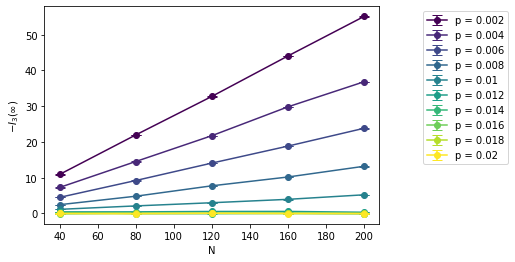

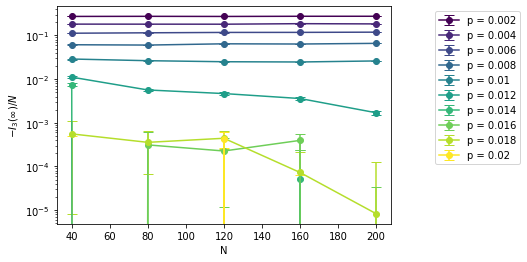

In [4]:
fig, ax = plt.subplots()

n = len(prob_array)
colors = plt.cm.viridis(np.linspace(0, 1, n))
ax.set_prop_cycle(cycler('color', colors))

for prob_index, prob in enumerate(prob_array):
    ax.errorbar(N_array,-saturated_I3_vs_N_p[:,prob_index],yerr=saturated_I3_error_vs_N_p[:,prob_index],
                 marker='o',capsize=5,label=f'p = {prob:.3g}')
    
plt.xlabel("N")
plt.ylabel(r"$-I_{3}(\infty)$")
plt.legend(bbox_to_anchor=(1.4,1.0))



fig, ax = plt.subplots()

n = len(prob_array)
colors = plt.cm.viridis(np.linspace(0, 1, n))
ax.set_prop_cycle(cycler('color', colors))

for prob_index, prob in enumerate(prob_array):
    ax.errorbar(N_array,-saturated_I3_vs_N_p[:,prob_index]/N_array,yerr=saturated_I3_error_vs_N_p[:,prob_index]/N_array,
                 marker='o',capsize=5,label=f'p = {prob:.3g}')
    
plt.xlabel("N")
plt.ylabel(r"$-I_{3}(\infty)/N$")
plt.legend(bbox_to_anchor=(1.4,1.0))
plt.yscale("log")

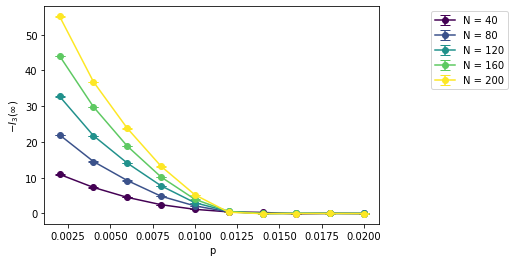

In [5]:
fig, ax = plt.subplots()

n = len(N_array)
colors = plt.cm.viridis(np.linspace(0, 1, n))
ax.set_prop_cycle(cycler('color', colors))

for N_index, N in enumerate(N_array):
    ax.errorbar(prob_array,-saturated_I3_vs_N_p[N_index,:],yerr=saturated_I3_error_vs_N_p[N_index,:],
                 marker='o',capsize=5,label=f'N = {N}')
    
plt.xlabel("p")
plt.ylabel(r"$-I_{3}(\infty)$")
plt.legend(bbox_to_anchor=(1.4,1.0))

In [28]:
start = 0
end = -1

def objective_function(params, args=(prob_array, N_array, saturated_I3_vs_N_p, saturated_I3_error_vs_N_p)):
    
    p_c = params[0]
    nu = params[1]
    
    x = np.power(N_array, 1/nu)[:,np.newaxis] * (prob_array - p_c)[start:end]
    x = x.flatten()
    sorting_indices = np.argsort(x)
    x = np.sort(x)
    n = len(x)
    
    y = saturated_I3_vs_N_p[:,start:end].flatten()[sorting_indices]
    d = saturated_I3_error_vs_N_p[:,start:end].flatten()[sorting_indices]
    
    O = (1/(n-2)) * np.sum([objective_w_function(x[i],y[i],d[i],x[i-1],y[i-1],d[i-1],x[i+1],y[i+1],d[i+1]) for i in range(1,n-1)])
    
    return O

In [29]:
x = np.arange(0.00801, 0.01601, 0.00002)
y = np.arange(0.5,2.5,0.001)

cost_array = np.array([[objective_function([p_c,nu]) for nu in y] for p_c in x])

x_arg, y_arg = np.unravel_index(np.argmin(cost_array, axis=None), cost_array.shape)
print("p_c = {:.4g}\nnu = {:.4g}".format(*[x[x_arg],y[y_arg]]))

p_c = 0.01329
nu = 1.92


In [30]:
coords = np.argwhere(cost_array < 1.3 * cost_array[x_arg,y_arg])
 
x_coords = coords[:,0]
y_coords = coords[:,1]
y_unique_indices = np.unique(y_coords)
indices = [np.argwhere(y_coords == y_uniq) for y_uniq in y_unique_indices]

x_bound_indices = [[np.min(x_coords[indices[i]]),np.max(x_coords[indices[i]])] for i in range(len(y_unique_indices))]

x_bounds = x[x_bound_indices]
x_bounds_min = x_bounds[:,0]
x_bounds_max = x_bounds[:,1]
y_bounds = y[y_unique_indices]

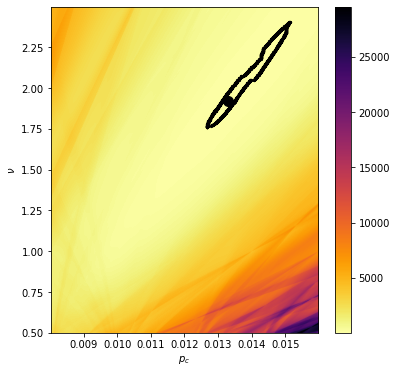

In [31]:
fig, ax = plt.subplots(figsize=(6,6))

# circle = plt.Circle((x[x_arg], y[y_arg]), 0.005, fc='black')
# plt.gca().add_patch(circle)

ax.scatter([x[x_arg]], [y[y_arg]], s=100, edgecolor="k", facecolor="black")

plt.imshow(np.transpose(cost_array), extent=[x[0],x[-1],y[-1],y[0]], aspect='auto', cmap='inferno_r')

plt.colorbar()

plt.xlabel(r"$p_{c}$")
plt.ylabel(r"$\nu$")

plt.scatter(x_bounds_min, y_bounds, s=5, color='black')
plt.scatter(x_bounds_max, y_bounds, s=5, color='black')

plt.xlim((x[0],x[-1]))
plt.ylim((y[0],y[-1]))
# plt.ylim((1.25,y[-1]))




plt.show()

Is it just a coincidence that this has a very similar $p_{c}$ to the hybrid MBL system? I hope I haven't done something wrong...

# 2D simulations

In [128]:
# Parameters

L = 8
N = L**2
num_steps = 30*L 
num_samples = 100 
prob = 0.02
num_disorder_realizations = 10

sample_times = np.rint(np.linspace(0, num_steps, num_samples)).astype(int)
sample_time_check_list = np.isin(np.arange(num_steps+1), sample_times)

unaveraged_entropies_vs_time = np.zeros((num_samples,num_disorder_realizations))

A = int(N/2)
ent_subsystem = np.arange(A).tolist()

m = 0
m = 1
m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
Steady state entropy = 15.8


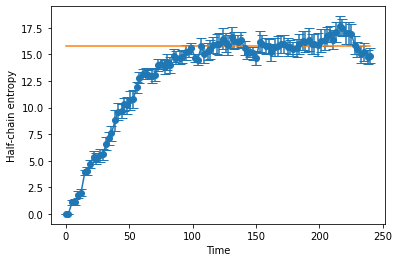

In [129]:

# Main

for m in range(num_disorder_realizations):
    
    print(f"m = {m}")
    
    gr = graphsim.GraphRegister(N)

    for n in range(num_steps):

        sublattice_parity = n % 2
        for v in range(sublattice_parity, sublattice_parity+N, 2):            
            gate_type = np.random.randint(0,3)
            if gate_type==0:
                clock_parity = n % 4
                v_neighbour = get_neighbour(v,clock_parity,L)
                gr.cphase(v,v_neighbour)
            elif gate_type==1:
                gr.hadamard(v)
            else:
                gr.phaserot(v)

        measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
        measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

        for v in measured_indices:
            gr.measure(v)

        if sample_time_check_list[n+1]:
            index = np.argwhere(sample_times == n+1)
            unaveraged_entropies_vs_time[index,m] = gr.entEntropy(ent_subsystem)
            
mean_entropies_vs_time = np.mean(unaveraged_entropies_vs_time, axis=1)
std_entropies_vs_time = np.sqrt(np.var(unaveraged_entropies_vs_time, axis=1) / num_disorder_realizations)

plt.errorbar(sample_times, mean_entropies_vs_time, yerr=std_entropies_vs_time, marker='o', capsize=5)
plt.xlabel("Time")
plt.ylabel("Half-chain entropy")

fit_start_index = int(0.9*num_samples)

popt, pcov = optimize.curve_fit(constant_fit, sample_times[fit_start_index:], mean_entropies_vs_time[fit_start_index:],
                                sigma=std_entropies_vs_time[fit_start_index:],absolute_sigma=True,
                                p0=[1])
plt.plot(sample_times, constant_fit(sample_times,*popt))
print("Steady state entropy = {:.3g}".format(popt[0]))

Text(0.5, 1.0, 'p = 0.01')

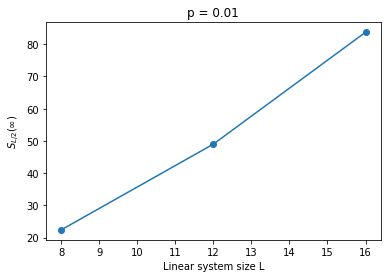

In [127]:
L_array = [8,12,16]
saturated_ent_entropy_vs_L = [22.4,49,83.7]

plt.plot(L_array, saturated_ent_entropy_vs_L, marker='o')
plt.xlabel("Linear system size L")
plt.ylabel(r"$S_{L/2}(\infty)$")
plt.title("p = 0.01")

# Entanglement clusters

In [51]:
# Parameters

N_array = [40,80,120]
prob_min= 0.02
prob_max = 0.2
num_prob_steps = 10
prob_array = np.linspace(prob_min, prob_max, num_prob_steps, endpoint=True)
num_disorder_realizations = 100

unaveraged_cluster_sizes_vs_p_N = np.zeros((num_disorder_realizations,num_prob_steps,len(N_array)))

In [ ]:
for N_index, N in enumerate(N_array):
    num_steps = 2*N
    for prob_index, prob in enumerate(prob_array):
        print(f"N = {N}, prob = {prob:.3g}")
        for m in range(num_disorder_realizations):
                
            gr = graphsim.GraphRegister(N)

            for n in range(num_steps):

                parity = n % 2 
                for v in range(parity, parity+N, 2): 
                    gate_type = np.random.choice([0,1,2,3,4],p=[0.95,0.0125,0.0125,0.0125,0.0125])
                    if gate_type==0:
                        gr.cnot(v,(v+1)%N)
                    elif gate_type==1:
                        gr.hadamard(v)
                        gr.hadamard((v+1)%N)
                    elif gate_type==2:
                        gr.hadamard(v)
                        gr.phaserot((v+1)%N)
                    elif gate_type==3:
                        gr.phaserot(v)
                        gr.hadamard((v+1)%N)
                    else:
                        gr.phaserot(v)
                        gr.phaserot((v+1)%N)

                measurement_list = np.random.choice([0,1], size=N, p=[1-prob, prob])
                measured_indices = np.argwhere(measurement_list > 0)[:,0].tolist()

                for v in measured_indices:
                    gr.measure(v)

            unaveraged_cluster_sizes_vs_p_N[m,prob_index,N_index] = gr.largestCluster()

N = 40, prob = 0.02
N = 40, prob = 0.04
N = 40, prob = 0.06
N = 40, prob = 0.08
N = 40, prob = 0.1
N = 40, prob = 0.12
N = 40, prob = 0.14
N = 40, prob = 0.16
N = 40, prob = 0.18
N = 40, prob = 0.2
N = 80, prob = 0.02
N = 80, prob = 0.04
N = 80, prob = 0.06
N = 80, prob = 0.08
N = 80, prob = 0.1
N = 80, prob = 0.12
N = 80, prob = 0.14
N = 80, prob = 0.16
N = 80, prob = 0.18
N = 80, prob = 0.2


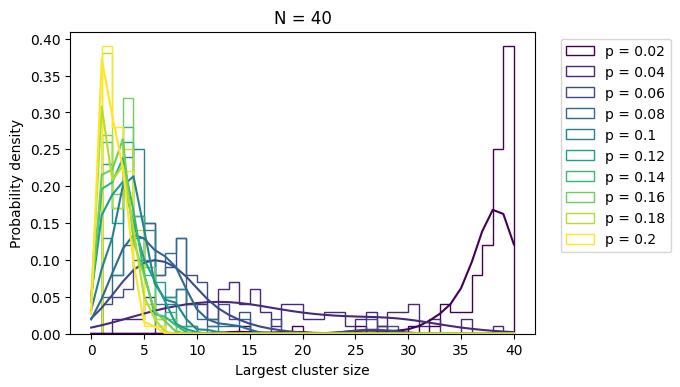

In [50]:
n = len(prob_array)
colors = plt.cm.viridis(np.linspace(0, 1, n))

for N_index, N in enumerate(N_array):
    fig, ax = plt.subplots(dpi=100)
    for prob_index, prob in enumerate(prob_array):
        _, x, _ = ax.hist(unaveraged_cluster_sizes_vs_p_N[:,prob_index,N_index], bins=np.arange(N+1),
                          density=True,histtype=u'step',color=colors[prob_index], label=f'p = {prob:.3g}')
        try:
            density = stats.gaussian_kde(unaveraged_cluster_sizes_vs_p_N[:,prob_index,N_index])
            ax.plot(x, density(x),color=colors[prob_index])
        except:
            pass
    plt.xlabel("Largest cluster size")
    plt.ylabel("Probability density")
    plt.legend(bbox_to_anchor=(1.04,1.0))
    plt.title(f"N = {N}")